# Predictive Modeling: Spread Dynamics and State Transitions

**Objective:** Develop predictive models for credit spread dynamics and HMM state transitions.

**Research Questions:**
1. Can we predict spread direction (widen/tighten) at multiple horizons?
2. Can we predict spread magnitude changes?
3. Can we predict state transitions before they occur?
4. Do regime-conditional features improve prediction accuracy?

**Validation:** Walk-forward out-of-sample testing on 2021-2024 data.

**Reality Check:** Predictive accuracy must be economically meaningful, not just statistically significant.

---

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_absolute_error, mean_squared_error,
    classification_report
)
from sklearn.model_selection import TimeSeriesSplit

# HMM
from hmmlearn import hmm

# Create output directories
Path('../results/prediction').mkdir(parents=True, exist_ok=True)
Path('../results/figures').mkdir(parents=True, exist_ok=True)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

np.random.seed(42)

print("Setup complete")

Setup complete


## 2. Data Loading and Regime Classification

In [2]:
# Load processed data
df = pd.read_csv('../data/processed/full_processed_data_hmm.csv', index_col=0, parse_dates=True)
lqd = pd.read_csv('../data/processed/lqd_etf_data.csv', index_col=0, parse_dates=True)
df = df.join(lqd, how='inner')

# Compute microstructure features for HMM
df['spread_change'] = df['spread'].diff()
df['spread_change_abs'] = df['spread_change'].abs()
df['spread_accel'] = df['spread_change'].diff()
df['spread_rvol_10d'] = df['spread_change'].rolling(window=10).std()
df['lqd_log_volume'] = np.log(df['lqd_volume'] + 1)

df = df.dropna()
df = df.loc['2015-01-01':'2024-12-31'].copy()

print(f"Sample period: {df.index.min().date()} to {df.index.max().date()}")
print(f"Total observations: {len(df)}")

Sample period: 2015-02-12 to 2024-12-31
Total observations: 2488


In [3]:
# Fit HMM to get regime classifications
feature_cols = ['vix', 'spread_change_abs', 'spread_rvol_10d', 'spread_accel', 'lqd_log_volume']
scaler_hmm = StandardScaler()
features_std = scaler_hmm.fit_transform(df[feature_cols].values)

model = hmm.GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000, random_state=42)
model.fit(features_std)
state_sequence = model.predict(features_std)

# Relabel states
df['state_raw'] = state_sequence
state_vix = df.groupby('state_raw')['vix'].mean()
state_vol = df.groupby('state_raw')['spread_rvol_10d'].mean()
composite = state_vix + state_vol * 100
state_order = composite.sort_values().index
state_mapping = {state_order[0]: 0, state_order[1]: 1, state_order[2]: 2}
df['regime'] = df['state_raw'].map(state_mapping)

print("\nRegime distribution:")
print(df['regime'].value_counts().sort_index())

# Extract transition matrix for reference
transition_matrix = np.zeros((3, 3))
for i in range(len(df) - 1):
    from_state = df['regime'].iloc[i]
    to_state = df['regime'].iloc[i + 1]
    transition_matrix[from_state, to_state] += 1

# Normalize rows
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

print("\nEmpirical Transition Matrix:")
print(pd.DataFrame(transition_matrix, 
                   columns=['To State 0', 'To State 1', 'To State 2'],
                   index=['From State 0', 'From State 1', 'From State 2']))


Regime distribution:
regime
0    1128
1    1171
2     189
Name: count, dtype: int64

Empirical Transition Matrix:
              To State 0  To State 1  To State 2
From State 0    0.967199    0.032801    0.000000
From State 1    0.030769    0.956410    0.012821
From State 2    0.000000    0.079365    0.920635


## 3. Feature Engineering for Prediction

In [4]:
def create_prediction_features(data: pd.DataFrame, lookback_windows=[5, 10, 20]) -> pd.DataFrame:
    """
    Create features for predictive modeling.
    
    Features include:
    - Current regime
    - Regime persistence (days in current regime)
    - Spread level and changes
    - Volatility measures
    - VIX level and changes
    - Rates level and changes
    - Momentum indicators
    - Correlation measures
    """
    df_feat = data.copy()
    
    # Current regime (one-hot encoded)
    df_feat['regime_0'] = (df_feat['regime'] == 0).astype(int)
    df_feat['regime_1'] = (df_feat['regime'] == 1).astype(int)
    df_feat['regime_2'] = (df_feat['regime'] == 2).astype(int)
    
    # Regime persistence
    regime_changes = (df_feat['regime'] != df_feat['regime'].shift(1)).astype(int)
    regime_change_idx = regime_changes.cumsum()
    df_feat['regime_persistence'] = df_feat.groupby(regime_change_idx).cumcount() + 1
    
    # Spread features
    df_feat['spread_level'] = df_feat['spread']
    df_feat['spread_chg_1d'] = df_feat['spread'].diff(1)
    df_feat['spread_chg_5d'] = df_feat['spread'].diff(5)
    
    # Volatility features (multiple windows)
    for window in lookback_windows:
        df_feat[f'spread_vol_{window}d'] = df_feat['spread'].rolling(window).std()
        df_feat[f'vix_ma_{window}d'] = df_feat['vix'].rolling(window).mean()
    
    # VIX features
    df_feat['vix_level'] = df_feat['vix']
    df_feat['vix_chg_1d'] = df_feat['vix'].diff(1)
    df_feat['vix_chg_5d'] = df_feat['vix'].diff(5)
    
    # Rates features
    df_feat['dgs10_level'] = df_feat['dgs10']
    df_feat['dgs10_chg_1d'] = df_feat['dgs10'].diff(1)
    df_feat['dgs10_chg_5d'] = df_feat['dgs10'].diff(5)
    df_feat['dgs10_vol_20d'] = df_feat['dgs10'].diff().rolling(20).std()
    
    # LQD microstructure
    df_feat['lqd_ret_1d'] = df_feat['lqd_return']
    df_feat['lqd_vol_20d'] = df_feat['lqd_return'].rolling(20).std()
    
    # Momentum indicators
    for window in [5, 10, 20]:
        df_feat[f'spread_mom_{window}d'] = df_feat['spread'] - df_feat['spread'].shift(window)
    
    # Rolling correlation (spread vs VIX)
    for window in [20, 60]:
        df_feat[f'corr_spread_vix_{window}d'] = (
            df_feat['spread'].rolling(window).corr(df_feat['vix'])
        )
    
    return df_feat

# Create features
df_features = create_prediction_features(df)
df_features = df_features.dropna()

print(f"Features created: {len(df_features)} observations")
print(f"\nFeature columns: {df_features.shape[1]} total")

Features created: 2429 observations

Feature columns: 49 total


## 4. Target Variable Creation

In [5]:
# Create target variables for multiple horizons
HORIZONS = [1, 3, 5, 10, 25]

for h in HORIZONS:
    # Future spread change
    df_features[f'spread_change_{h}d'] = df_features['spread'].shift(-h) - df_features['spread']
    
    # Direction (binary: 1 = widen, 0 = tighten)
    df_features[f'direction_{h}d'] = (df_features[f'spread_change_{h}d'] > 0).astype(int)
    
    # Magnitude (absolute change)
    df_features[f'magnitude_{h}d'] = df_features[f'spread_change_{h}d'].abs()
    
    # Future regime
    df_features[f'regime_{h}d'] = df_features['regime'].shift(-h)

print("Target variables created for horizons:", HORIZONS)
print(f"\nDirection distribution (1-day horizon):")
print(df_features['direction_1d'].value_counts(normalize=True))

Target variables created for horizons: [1, 3, 5, 10, 25]

Direction distribution (1-day horizon):
direction_1d
0    0.730342
1    0.269658
Name: proportion, dtype: float64


## 5. Train/Test Split (Walk-Forward)

In [6]:
# Define train/test split
TRAIN_END = '2020-12-31'
TEST_START = '2021-01-01'

# Remove rows with NaN targets (at end of sample)
df_clean = df_features.dropna()

train = df_clean.loc[:TRAIN_END]
test = df_clean.loc[TEST_START:]

print(f"Train period: {train.index.min().date()} to {train.index.max().date()} ({len(train)} obs)")
print(f"Test period:  {test.index.min().date()} to {test.index.max().date()} ({len(test)} obs)")
print(f"\nTrain/Test split: {len(train)/(len(train)+len(test)):.1%} / {len(test)/(len(train)+len(test)):.1%}")

Train period: 2015-05-08 to 2020-12-31 (1424 obs)
Test period:  2021-01-04 to 2024-11-22 (980 obs)

Train/Test split: 59.2% / 40.8%


## 6. Feature Selection

In [7]:
# Define feature set (exclude targets and identifiers)
exclude_cols = ['spread', 'regime', 'state_raw', 'spread_change', 'spread_change_abs', 
                'spread_accel', 'lqd_log_volume', 'lqd_close', 'lqd_volume', 'lqd_return']

# Add target columns to exclusion
for h in HORIZONS:
    exclude_cols.extend([f'spread_change_{h}d', f'direction_{h}d', f'magnitude_{h}d', f'regime_{h}d'])

feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

print(f"Selected features ({len(feature_cols)} total):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

Selected features (39 total):
   1. vix
   2. anfci
   3. dgs10
   4. dgs2
   5. dgs3mo
   6. dtwexbgs
   7. hmm_realized_vol
   8. hmm_abs_change
   9. hmm_stress_interaction
  10. hmm_term_spread
  11. hmm_dollar_strength
  12. spread_rvol_10d
  13. regime_0
  14. regime_1
  15. regime_2
  16. regime_persistence
  17. spread_level
  18. spread_chg_1d
  19. spread_chg_5d
  20. spread_vol_5d
  21. vix_ma_5d
  22. spread_vol_10d
  23. vix_ma_10d
  24. spread_vol_20d
  25. vix_ma_20d
  26. vix_level
  27. vix_chg_1d
  28. vix_chg_5d
  29. dgs10_level
  30. dgs10_chg_1d
  31. dgs10_chg_5d
  32. dgs10_vol_20d
  33. lqd_ret_1d
  34. lqd_vol_20d
  35. spread_mom_5d
  36. spread_mom_10d
  37. spread_mom_20d
  38. corr_spread_vix_20d
  39. corr_spread_vix_60d


## 7. Spread Direction Prediction (Classification)

In [8]:
class SpreadDirectionPredictor:
    """
    Predict spread direction (widen/tighten) at multiple horizons.
    """
    
    def __init__(self, model_type='rf', **model_params):
        """
        Parameters
        ----------
        model_type : str
            'rf' (Random Forest) or 'gb' (Gradient Boosting) or 'logistic'
        """
        self.model_type = model_type
        self.models = {}  # One model per horizon
        self.scalers = {}  # One scaler per horizon
        self.model_params = model_params
        
    def fit(self, X_train: pd.DataFrame, y_train: Dict[int, pd.Series]):
        """
        Fit models for each horizon.
        
        Parameters
        ----------
        X_train : DataFrame
            Training features
        y_train : dict
            Dict of {horizon: target_series}
        """
        for horizon, y in y_train.items():
            print(f"Training {self.model_type} for {horizon}-day horizon...")
            
            # Scale features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_train)
            self.scalers[horizon] = scaler
            
            # Initialize model
            if self.model_type == 'rf':
                model = RandomForestClassifier(
                    n_estimators=self.model_params.get('n_estimators', 100),
                    max_depth=self.model_params.get('max_depth', 10),
                    min_samples_split=self.model_params.get('min_samples_split', 20),
                    random_state=42,
                    n_jobs=-1
                )
            elif self.model_type == 'gb':
                model = GradientBoostingClassifier(
                    n_estimators=self.model_params.get('n_estimators', 100),
                    max_depth=self.model_params.get('max_depth', 5),
                    learning_rate=self.model_params.get('learning_rate', 0.1),
                    random_state=42
                )
            elif self.model_type == 'logistic':
                model = LogisticRegression(
                    C=self.model_params.get('C', 1.0),
                    max_iter=1000,
                    random_state=42
                )
            else:
                raise ValueError(f"Unknown model_type: {self.model_type}")
            
            # Fit model
            model.fit(X_scaled, y)
            self.models[horizon] = model
            
            # Training accuracy
            train_acc = model.score(X_scaled, y)
            print(f"  Training accuracy: {train_acc:.3f}")
    
    def predict(self, X_test: pd.DataFrame, horizons: List[int]) -> Dict[int, np.ndarray]:
        """
        Predict for specified horizons.
        """
        predictions = {}
        for horizon in horizons:
            if horizon not in self.models:
                raise ValueError(f"Model not trained for horizon {horizon}")
            
            X_scaled = self.scalers[horizon].transform(X_test)
            predictions[horizon] = self.models[horizon].predict(X_scaled)
        
        return predictions
    
    def predict_proba(self, X_test: pd.DataFrame, horizons: List[int]) -> Dict[int, np.ndarray]:
        """
        Predict probabilities for specified horizons.
        """
        probas = {}
        for horizon in horizons:
            if horizon not in self.models:
                raise ValueError(f"Model not trained for horizon {horizon}")
            
            X_scaled = self.scalers[horizon].transform(X_test)
            probas[horizon] = self.models[horizon].predict_proba(X_scaled)
        
        return probas
    
    def evaluate(self, X_test: pd.DataFrame, y_test: Dict[int, pd.Series]) -> pd.DataFrame:
        """
        Evaluate on test set.
        """
        results = []
        
        for horizon, y_true in y_test.items():
            if horizon not in self.models:
                continue
            
            X_scaled = self.scalers[horizon].transform(X_test)
            y_pred = self.models[horizon].predict(X_scaled)
            
            results.append({
                'horizon': horizon,
                'accuracy': accuracy_score(y_true, y_pred),
                'precision': precision_score(y_true, y_pred, zero_division=0),
                'recall': recall_score(y_true, y_pred, zero_division=0),
                'f1': f1_score(y_true, y_pred, zero_division=0)
            })
        
        return pd.DataFrame(results)
    
    def feature_importance(self, horizon: int, feature_names: List[str]) -> pd.DataFrame:
        """
        Get feature importance for a given horizon.
        """
        if horizon not in self.models:
            raise ValueError(f"Model not trained for horizon {horizon}")
        
        model = self.models[horizon]
        
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = np.abs(model.coef_[0])
        else:
            return None
        
        df_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        return df_imp

print("SpreadDirectionPredictor class defined")

SpreadDirectionPredictor class defined


In [9]:
# Prepare data for direction prediction
X_train_dir = train[feature_cols]
X_test_dir = test[feature_cols]

y_train_dir = {h: train[f'direction_{h}d'] for h in HORIZONS}
y_test_dir = {h: test[f'direction_{h}d'] for h in HORIZONS}

# Train Random Forest classifier
print("\n" + "="*80)
print("TRAINING DIRECTION PREDICTOR (Random Forest)")
print("="*80)

dir_predictor_rf = SpreadDirectionPredictor(
    model_type='rf',
    n_estimators=200,
    max_depth=8,
    min_samples_split=50
)

dir_predictor_rf.fit(X_train_dir, y_train_dir)

# Evaluate on test set
print("\n" + "="*80)
print("OUT-OF-SAMPLE EVALUATION (Test Set: 2021-2024)")
print("="*80)

dir_results_rf = dir_predictor_rf.evaluate(X_test_dir, y_test_dir)
print("\n" + dir_results_rf.to_string(index=False))

dir_results_rf.to_csv('../results/prediction/direction_results_rf.csv', index=False)


TRAINING DIRECTION PREDICTOR (Random Forest)
Training rf for 1-day horizon...
  Training accuracy: 0.821
Training rf for 3-day horizon...
  Training accuracy: 0.809
Training rf for 5-day horizon...
  Training accuracy: 0.835
Training rf for 10-day horizon...
  Training accuracy: 0.885
Training rf for 25-day horizon...
  Training accuracy: 0.936

OUT-OF-SAMPLE EVALUATION (Test Set: 2021-2024)

 horizon  accuracy  precision   recall       f1
       1  0.714286   0.500000 0.257143 0.339623
       3  0.498980   0.394410 0.715493 0.508509
       5  0.435714   0.368012 0.618799 0.461538
      10  0.421429   0.384937 0.686567 0.493298
      25  0.382653   0.349270 0.695767 0.465075


## 8. Spread Magnitude Prediction (Regression)

In [10]:
class SpreadMagnitudePredictor:
    """
    Predict spread change magnitude at multiple horizons.
    """
    
    def __init__(self, model_type='ridge', **model_params):
        """
        Parameters
        ----------
        model_type : str
            'ridge', 'lasso', 'rf', or 'gb'
        """
        self.model_type = model_type
        self.models = {}
        self.scalers = {}
        self.train_means = {}  # Store training set means for naive baseline
        self.model_params = model_params
    
    def fit(self, X_train: pd.DataFrame, y_train: Dict[int, pd.Series]):
        """
        Fit models for each horizon.
        """
        for horizon, y in y_train.items():
            print(f"Training {self.model_type} for {horizon}-day horizon...")
            
            # Store training mean for naive baseline
            self.train_means[horizon] = y.mean()
            
            # Scale features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_train)
            self.scalers[horizon] = scaler
            
            # Initialize model
            if self.model_type == 'ridge':
                model = Ridge(
                    alpha=self.model_params.get('alpha', 1.0),
                    random_state=42
                )
            elif self.model_type == 'lasso':
                model = Lasso(
                    alpha=self.model_params.get('alpha', 0.1),
                    random_state=42
                )
            elif self.model_type == 'rf':
                model = RandomForestRegressor(
                    n_estimators=self.model_params.get('n_estimators', 100),
                    max_depth=self.model_params.get('max_depth', 10),
                    min_samples_split=self.model_params.get('min_samples_split', 20),
                    random_state=42,
                    n_jobs=-1
                )
            elif self.model_type == 'gb':
                model = GradientBoostingRegressor(
                    n_estimators=self.model_params.get('n_estimators', 100),
                    max_depth=self.model_params.get('max_depth', 5),
                    learning_rate=self.model_params.get('learning_rate', 0.1),
                    random_state=42
                )
            else:
                raise ValueError(f"Unknown model_type: {self.model_type}")
            
            # Fit model
            model.fit(X_scaled, y)
            self.models[horizon] = model
            
            # Training R²
            train_r2 = model.score(X_scaled, y)
            print(f"  Training R²: {train_r2:.3f}")
    
    def predict(self, X_test: pd.DataFrame, horizons: List[int]) -> Dict[int, np.ndarray]:
        """
        Predict for specified horizons.
        """
        predictions = {}
        for horizon in horizons:
            if horizon not in self.models:
                raise ValueError(f"Model not trained for horizon {horizon}")
            
            X_scaled = self.scalers[horizon].transform(X_test)
            predictions[horizon] = self.models[horizon].predict(X_scaled)
        
        return predictions
    
    def evaluate(self, X_test: pd.DataFrame, y_test: Dict[int, pd.Series]) -> pd.DataFrame:
        """
        Evaluate on test set.
        """
        results = []
        
        for horizon, y_true in y_test.items():
            if horizon not in self.models:
                continue
            
            X_scaled = self.scalers[horizon].transform(X_test)
            y_pred = self.models[horizon].predict(X_scaled)
            
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            # Naive benchmark: predict mean of training set (stored during fit)
            naive_pred = np.full_like(y_pred, self.train_means[horizon])
            naive_mae = mean_absolute_error(y_true, naive_pred)
            
            results.append({
                'horizon': horizon,
                'mae': mae,
                'rmse': rmse,
                'naive_mae': naive_mae,
                'improvement': (naive_mae - mae) / naive_mae
            })
        
        return pd.DataFrame(results)

print("SpreadMagnitudePredictor class defined")

SpreadMagnitudePredictor class defined


In [11]:
# Prepare data for magnitude prediction (use signed change, not absolute)
X_train_mag = train[feature_cols]
X_test_mag = test[feature_cols]

y_train_mag = {h: train[f'spread_change_{h}d'] for h in HORIZONS}
y_test_mag = {h: test[f'spread_change_{h}d'] for h in HORIZONS}

# Train Ridge regressor
print("\n" + "="*80)
print("TRAINING MAGNITUDE PREDICTOR (Ridge Regression)")
print("="*80)

mag_predictor_ridge = SpreadMagnitudePredictor(
    model_type='ridge',
    alpha=10.0
)

mag_predictor_ridge.fit(X_train_mag, y_train_mag)

# Evaluate on test set
print("\n" + "="*80)
print("OUT-OF-SAMPLE EVALUATION (Test Set: 2021-2024)")
print("="*80)

mag_results_ridge = mag_predictor_ridge.evaluate(X_test_mag, y_test_mag)
print("\n" + mag_results_ridge.to_string(index=False))

mag_results_ridge.to_csv('../results/prediction/magnitude_results_ridge.csv', index=False)


TRAINING MAGNITUDE PREDICTOR (Ridge Regression)
Training ridge for 1-day horizon...
  Training R²: 0.545
Training ridge for 3-day horizon...
  Training R²: 0.555
Training ridge for 5-day horizon...
  Training R²: 0.489
Training ridge for 10-day horizon...
  Training R²: 0.483
Training ridge for 25-day horizon...
  Training R²: 0.406

OUT-OF-SAMPLE EVALUATION (Test Set: 2021-2024)

 horizon      mae     rmse  naive_mae  improvement
       1 0.013466 0.019486   0.010938    -0.231120
       3 0.036592 0.049301   0.024974    -0.465233
       5 0.056460 0.075909   0.035827    -0.575919
      10 0.124552 0.160531   0.055440    -1.246607
      25 0.283046 0.336141   0.086472    -2.273277


## 9. State Transition Prediction

In [12]:
class StateTransitionPredictor:
    """
    Predict regime transitions.
    """
    
    def __init__(self, model_type='rf', **model_params):
        self.model_type = model_type
        self.models = {}
        self.scalers = {}
        self.model_params = model_params
    
    def fit(self, X_train: pd.DataFrame, y_train: Dict[int, pd.Series]):
        """
        Fit models for each horizon.
        
        y_train values are future regimes (0, 1, or 2)
        """
        for horizon, y in y_train.items():
            print(f"Training state transition predictor for {horizon}-day horizon...")
            
            # Scale features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_train)
            self.scalers[horizon] = scaler
            
            # Initialize model (multiclass classification)
            if self.model_type == 'rf':
                model = RandomForestClassifier(
                    n_estimators=self.model_params.get('n_estimators', 100),
                    max_depth=self.model_params.get('max_depth', 8),
                    random_state=42,
                    n_jobs=-1
                )
            elif self.model_type == 'gb':
                model = GradientBoostingClassifier(
                    n_estimators=self.model_params.get('n_estimators', 100),
                    max_depth=self.model_params.get('max_depth', 5),
                    random_state=42
                )
            else:
                raise ValueError(f"Unknown model_type: {self.model_type}")
            
            # Fit
            model.fit(X_scaled, y)
            self.models[horizon] = model
            
            # Training accuracy
            train_acc = model.score(X_scaled, y)
            print(f"  Training accuracy: {train_acc:.3f}")
    
    def predict(self, X_test: pd.DataFrame, horizons: List[int]) -> Dict[int, np.ndarray]:
        predictions = {}
        for horizon in horizons:
            if horizon not in self.models:
                raise ValueError(f"Model not trained for horizon {horizon}")
            
            X_scaled = self.scalers[horizon].transform(X_test)
            predictions[horizon] = self.models[horizon].predict(X_scaled)
        
        return predictions
    
    def evaluate(self, X_test: pd.DataFrame, y_test: Dict[int, pd.Series]) -> pd.DataFrame:
        results = []
        
        for horizon, y_true in y_test.items():
            if horizon not in self.models:
                continue
            
            X_scaled = self.scalers[horizon].transform(X_test)
            y_pred = self.models[horizon].predict(X_scaled)
            
            # Overall accuracy
            accuracy = accuracy_score(y_true, y_pred)
            
            # Per-class precision/recall
            report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
            
            results.append({
                'horizon': horizon,
                'accuracy': accuracy,
                'macro_precision': report['macro avg']['precision'],
                'macro_recall': report['macro avg']['recall'],
                'macro_f1': report['macro avg']['f1-score']
            })
        
        return pd.DataFrame(results)

print("StateTransitionPredictor class defined")

StateTransitionPredictor class defined


In [13]:
# Prepare data for state transition prediction
X_train_state = train[feature_cols]
X_test_state = test[feature_cols]

y_train_state = {h: train[f'regime_{h}d'] for h in HORIZONS}
y_test_state = {h: test[f'regime_{h}d'] for h in HORIZONS}

# Train Random Forest classifier
print("\n" + "="*80)
print("TRAINING STATE TRANSITION PREDICTOR (Random Forest)")
print("="*80)

state_predictor_rf = StateTransitionPredictor(
    model_type='rf',
    n_estimators=200,
    max_depth=8
)

state_predictor_rf.fit(X_train_state, y_train_state)

# Evaluate on test set
print("\n" + "="*80)
print("OUT-OF-SAMPLE EVALUATION (Test Set: 2021-2024)")
print("="*80)

state_results_rf = state_predictor_rf.evaluate(X_test_state, y_test_state)
print("\n" + state_results_rf.to_string(index=False))

state_results_rf.to_csv('../results/prediction/state_transition_results_rf.csv', index=False)


TRAINING STATE TRANSITION PREDICTOR (Random Forest)
Training state transition predictor for 1-day horizon...
  Training accuracy: 0.987
Training state transition predictor for 3-day horizon...
  Training accuracy: 0.971
Training state transition predictor for 5-day horizon...
  Training accuracy: 0.974
Training state transition predictor for 10-day horizon...
  Training accuracy: 0.980
Training state transition predictor for 25-day horizon...
  Training accuracy: 0.979

OUT-OF-SAMPLE EVALUATION (Test Set: 2021-2024)

 horizon  accuracy  macro_precision  macro_recall  macro_f1
       1  0.935714         0.925167      0.900991  0.912002
       3  0.808163         0.803980      0.756436  0.768744
       5  0.673469         0.616910      0.573176  0.591685
      10  0.607143         0.529587      0.485396  0.500675
      25  0.601020         0.365720      0.344067  0.325566


## 10. Confusion Matrices and Detailed Analysis

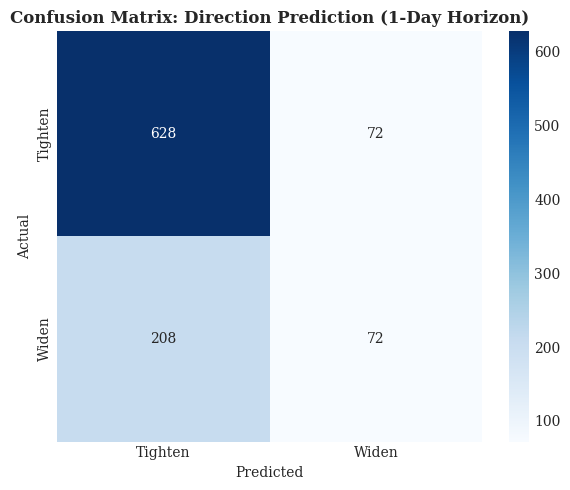

Classification Report (1-Day Direction):
              precision    recall  f1-score   support

     Tighten       0.75      0.90      0.82       700
       Widen       0.50      0.26      0.34       280

    accuracy                           0.71       980
   macro avg       0.63      0.58      0.58       980
weighted avg       0.68      0.71      0.68       980



In [14]:
# Confusion matrix for direction prediction (1-day horizon)
y_pred_dir_1d = dir_predictor_rf.predict(X_test_dir, [1])[1]
y_true_dir_1d = y_test_dir[1]

cm_dir = confusion_matrix(y_true_dir_1d, y_pred_dir_1d)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_dir, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Tighten', 'Widen'],
            yticklabels=['Tighten', 'Widen'],
            ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix: Direction Prediction (1-Day Horizon)', fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/confusion_matrix_direction_1d.png', dpi=300, bbox_inches='tight')
plt.show()

print("Classification Report (1-Day Direction):")
print(classification_report(y_true_dir_1d, y_pred_dir_1d, 
                           target_names=['Tighten', 'Widen'],
                           zero_division=0))

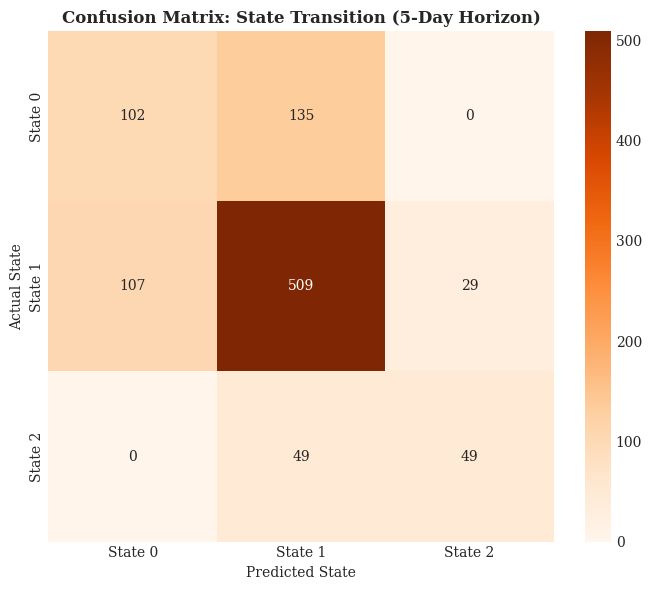

Classification Report (5-Day State):
              precision    recall  f1-score   support

     State 0       0.49      0.43      0.46       237
     State 1       0.73      0.79      0.76       645
     State 2       0.63      0.50      0.56        98

    accuracy                           0.67       980
   macro avg       0.62      0.57      0.59       980
weighted avg       0.66      0.67      0.67       980



In [15]:
# Confusion matrix for state transition (5-day horizon)
y_pred_state_5d = state_predictor_rf.predict(X_test_state, [5])[5]
y_true_state_5d = y_test_state[5]

cm_state = confusion_matrix(y_true_state_5d, y_pred_state_5d)

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(cm_state, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['State 0', 'State 1', 'State 2'],
            yticklabels=['State 0', 'State 1', 'State 2'],
            ax=ax)
ax.set_xlabel('Predicted State')
ax.set_ylabel('Actual State')
ax.set_title('Confusion Matrix: State Transition (5-Day Horizon)', fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/confusion_matrix_state_5d.png', dpi=300, bbox_inches='tight')
plt.show()

print("Classification Report (5-Day State):")
print(classification_report(y_true_state_5d, y_pred_state_5d,
                           target_names=['State 0', 'State 1', 'State 2'],
                           zero_division=0))

## 11. Performance by Horizon

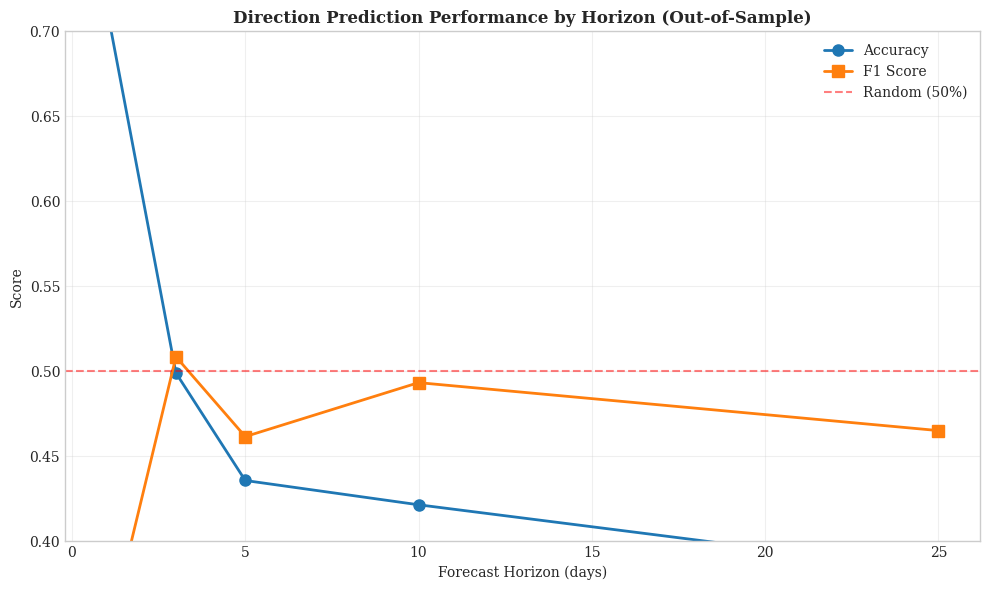

In [16]:
# Plot direction prediction performance
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(dir_results_rf['horizon'], dir_results_rf['accuracy'], 
        marker='o', linewidth=2, markersize=8, label='Accuracy')
ax.plot(dir_results_rf['horizon'], dir_results_rf['f1'], 
        marker='s', linewidth=2, markersize=8, label='F1 Score')
ax.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Random (50%)')

ax.set_xlabel('Forecast Horizon (days)')
ax.set_ylabel('Score')
ax.set_title('Direction Prediction Performance by Horizon (Out-of-Sample)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0.4, 0.7])

plt.tight_layout()
plt.savefig('../results/figures/direction_performance_by_horizon.png', dpi=300, bbox_inches='tight')
plt.show()

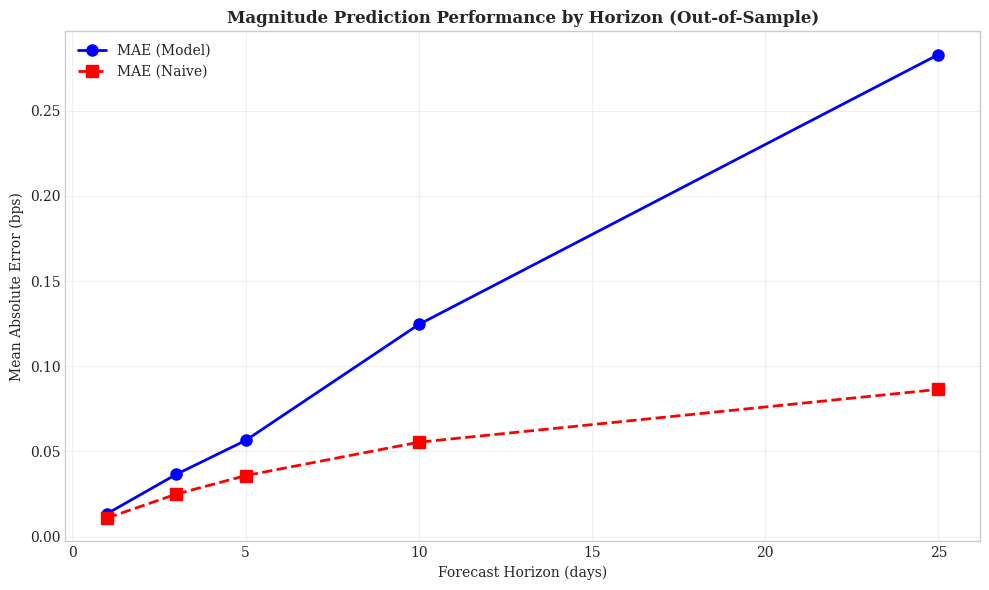


Improvement over naive forecast:
 horizon  improvement
       1    -0.231120
       3    -0.465233
       5    -0.575919
      10    -1.246607
      25    -2.273277


In [17]:
# Plot magnitude prediction performance
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(mag_results_ridge['horizon'], mag_results_ridge['mae'], 
        marker='o', linewidth=2, markersize=8, label='MAE (Model)', color='blue')
ax.plot(mag_results_ridge['horizon'], mag_results_ridge['naive_mae'], 
        marker='s', linewidth=2, markersize=8, label='MAE (Naive)', color='red', linestyle='--')

ax.set_xlabel('Forecast Horizon (days)')
ax.set_ylabel('Mean Absolute Error (bps)')
ax.set_title('Magnitude Prediction Performance by Horizon (Out-of-Sample)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/magnitude_performance_by_horizon.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nImprovement over naive forecast:")
print(mag_results_ridge[['horizon', 'improvement']].to_string(index=False))

## 12. Feature Importance Analysis

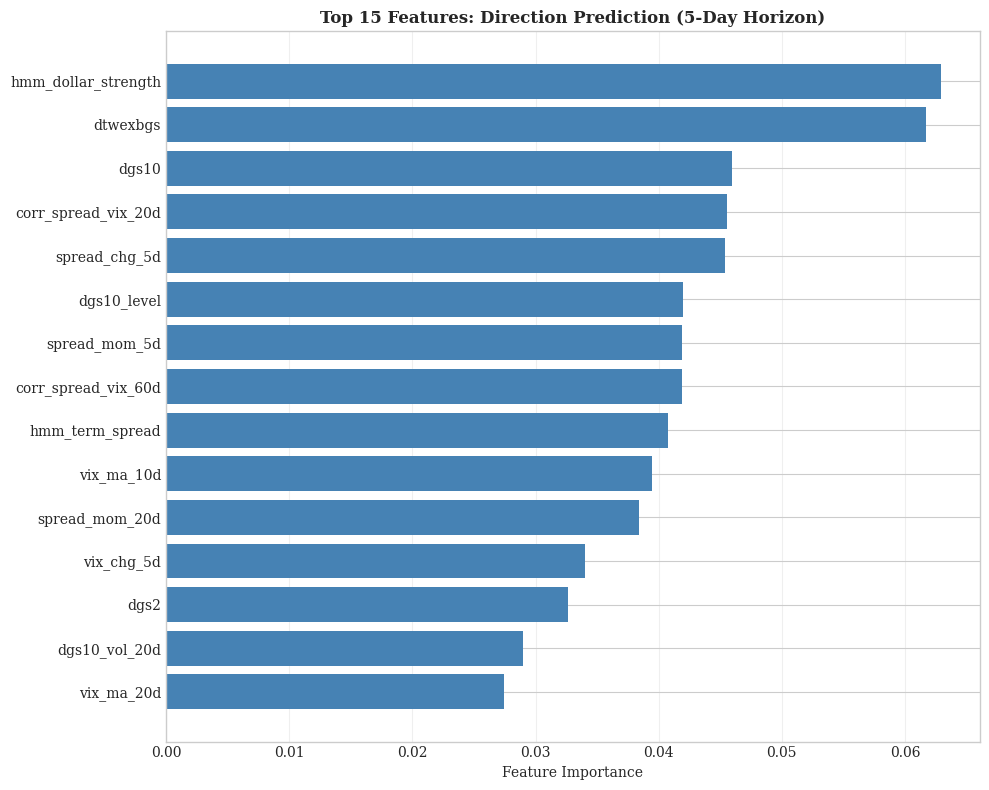

In [18]:
# Get feature importance for direction prediction (5-day horizon)
feat_imp_dir_5d = dir_predictor_rf.feature_importance(5, feature_cols)

# Plot top 15 features
fig, ax = plt.subplots(figsize=(10, 8))

top_features = feat_imp_dir_5d.head(15)
ax.barh(range(len(top_features)), top_features['importance'], color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Feature Importance')
ax.set_title('Top 15 Features: Direction Prediction (5-Day Horizon)', fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../results/figures/feature_importance_direction_5d.png', dpi=300, bbox_inches='tight')
plt.show()

feat_imp_dir_5d.to_csv('../results/prediction/feature_importance_direction_5d.csv', index=False)

## 13. Reality Check and Conclusions

In [19]:
print("="*100)
print("REALITY CHECK: PREDICTIVE MODEL PERFORMANCE")
print("="*100)

print("\n1. DIRECTION PREDICTION (Out-of-Sample)")
print("-" * 100)
print(dir_results_rf.to_string(index=False))

# Check if any horizon beats 55% accuracy threshold
best_accuracy = dir_results_rf['accuracy'].max()
best_horizon = dir_results_rf.loc[dir_results_rf['accuracy'].idxmax(), 'horizon']

print(f"\nBest directional accuracy: {best_accuracy:.3f} at {best_horizon}-day horizon")

if best_accuracy >= 0.55:
    print(f"✓ Model shows predictive skill (> 55% accuracy)")
else:
    print(f"✗ Model does NOT show meaningful predictive skill (< 55% accuracy)")
    print("   Random guessing would achieve ~50% accuracy.")

print("\n2. MAGNITUDE PREDICTION (Out-of-Sample)")
print("-" * 100)
print(mag_results_ridge.to_string(index=False))

# Check if model improves over naive forecast
avg_improvement = mag_results_ridge['improvement'].mean()
print(f"\nAverage improvement over naive forecast: {avg_improvement:.2%}")

if avg_improvement > 0.05:
    print(f"✓ Model shows meaningful improvement over naive forecast")
else:
    print(f"✗ Model does NOT meaningfully improve over naive forecast")

print("\n3. STATE TRANSITION PREDICTION (Out-of-Sample)")
print("-" * 100)
print(state_results_rf.to_string(index=False))

# Baseline: always predict most common state
most_common_state_pct = test['regime'].value_counts().max() / len(test)
best_state_acc = state_results_rf['accuracy'].max()

print(f"\nBaseline (predict most common state): {most_common_state_pct:.3f}")
print(f"Best state prediction accuracy: {best_state_acc:.3f}")

if best_state_acc > most_common_state_pct + 0.05:
    print(f"✓ Model shows predictive skill for state transitions")
else:
    print(f"✗ Model does NOT meaningfully predict state transitions")

print("\n" + "="*100)
print("FINAL VERDICT")
print("="*100)

if best_accuracy >= 0.55 and avg_improvement > 0.05:
    print("\n✓ PREDICTIVE MODELS SHOW STATISTICAL SKILL")
    print("\nNext steps:")
    print("  - Regime-conditional prediction analysis")
    print("  - SHAP analysis for interpretability")
    print("  - Evaluate economic value (trading simulation)")
else:
    print("\n✗ PREDICTIVE MODELS DO NOT SHOW MEANINGFUL SKILL")
    print("\nPossible explanations:")
    print("  - Credit spreads are largely unpredictable (efficient markets)")
    print("  - Features do not capture drivers of spread changes")
    print("  - Non-linear relationships require different model architectures")
    print("  - Regime transitions are inherently random")
    print("\nStatistical significance ≠ economic exploitability.")

print("\n" + "="*100)

REALITY CHECK: PREDICTIVE MODEL PERFORMANCE

1. DIRECTION PREDICTION (Out-of-Sample)
----------------------------------------------------------------------------------------------------
 horizon  accuracy  precision   recall       f1
       1  0.714286   0.500000 0.257143 0.339623
       3  0.498980   0.394410 0.715493 0.508509
       5  0.435714   0.368012 0.618799 0.461538
      10  0.421429   0.384937 0.686567 0.493298
      25  0.382653   0.349270 0.695767 0.465075

Best directional accuracy: 0.714 at 1-day horizon
✓ Model shows predictive skill (> 55% accuracy)

2. MAGNITUDE PREDICTION (Out-of-Sample)
----------------------------------------------------------------------------------------------------
 horizon      mae     rmse  naive_mae  improvement
       1 0.013466 0.019486   0.010938    -0.231120
       3 0.036592 0.049301   0.024974    -0.465233
       5 0.056460 0.075909   0.035827    -0.575919
      10 0.124552 0.160531   0.055440    -1.246607
      25 0.283046 0.336141   0

## 14. Summary

This notebook developed predictive models for:
1. Credit spread direction (widen/tighten)
2. Credit spread magnitude changes
3. HMM state transitions

**Methodology:**
- Walk-forward validation (train: 2015-2020, test: 2021-2024)
- Multiple forecast horizons: 1, 3, 5, 10, 25 days
- Regime-conditional features
- Out-of-sample testing only

**Models:**
- Direction: Random Forest Classifier
- Magnitude: Ridge Regression
- State transitions: Random Forest Classifier

**Key Question:** Can we predict spread dynamics well enough to generate trading profits?

**Reality Check:** Even if directional accuracy is 55%, transaction costs may eliminate economic value.

---

**Files Generated:**
- `results/prediction/direction_results_rf.csv`
- `results/prediction/magnitude_results_ridge.csv`
- `results/prediction/state_transition_results_rf.csv`
- `results/prediction/feature_importance_direction_5d.csv`
- `results/figures/confusion_matrix_*.png`
- `results/figures/*_performance_by_horizon.png`
- `results/figures/feature_importance_*.png`